<a href="https://colab.research.google.com/github/Karthick47v2/speech-emotion-classifier/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download uwrfkaggler/ravdess-emotional-speech-audio
! unzip ravdess-emotional-speech-audio

In [ ]:
import glob
import pandas as pd
import numpy as np
import random
import cv2
import librosa 
import librosa.display
import matplotlib.pyplot as plt

import IPython.display as ipd

In [ ]:
# 1 - neutral 
# 2 - calm 
# 3 - happy
# 4 - sad
# 5 - angry
# 6 - fear
# 7 - disgust 
# 8 - surprise

# NOT NOWWWWWWWWW
# Calm, Happy, Surprise as POSTITIVE (1)  (2,3,8)
# Sad Fear Disgust Neutral as NEGATIVE (0) (1,4,6,7)
# drop Angry

# all are 48000 Hz
# mono

In [ ]:
path_list = glob.glob('/content/Actor_*/**')
emotion_list = [int((x.split('.')[0]).split('-')[2]) for x in path_list]

df = pd.DataFrame({'path': path_list, 'emotion': emotion_list})

In [ ]:
wav_len = []

for path in df['path']:
  y, sr = librosa.load(path, sr=None, mono=True)

  wav_len.append(y.shape[0] / sr)

df['length'] = wav_len

In [ ]:
df.groupby(['emotion'])['length'].mean()

emotion
1    3.503153
2    3.795806
3    3.638183
4    3.694490
5    3.871404
6    3.574231
7    3.941785
8    3.487512
Name: length, dtype: float64

In [ ]:
df['emotion'].value_counts()

8    192
2    192
7    192
5    192
3    192
6    192
4    192
1     96
Name: emotion, dtype: int64

In [ ]:
df.head()

,path,emotion,length
0,/content/Actor_22/03-01-08-01-02-01-22.wav,8,3.436771
1,/content/Actor_22/03-01-02-01-01-01-22.wav,2,3.536854
2,/content/Actor_22/03-01-07-01-02-01-22.wav,7,3.803792
3,/content/Actor_22/03-01-01-01-01-01-22.wav,1,3.636979
4,/content/Actor_22/03-01-05-01-02-01-22.wav,5,3.870521


In [ ]:
y, sr = librosa.load(df['path'][0], sr=None, mono=True)

print(row['emotion'])
print(row['length'])

1
3.370041666666667


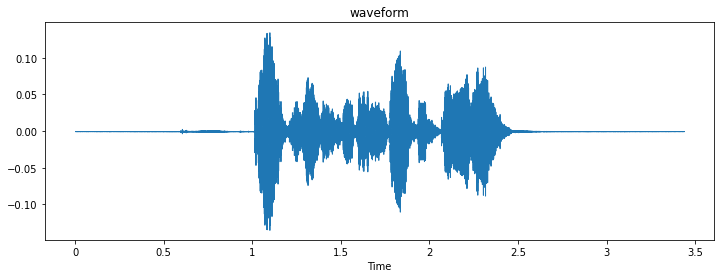

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr)
plt.title('waveform')
plt.show()

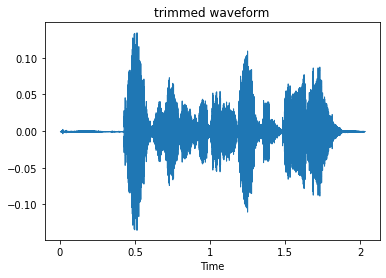

In [ ]:
trimmed_y, idx = librosa.effects.trim(y, top_db=50) 
librosa.display.waveshow(trimmed_y, sr=sr)
plt.title('trimmed waveform')
plt.show()

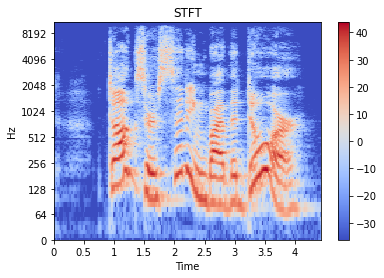

In [ ]:
n_fft = 2048
hop_length = 512

# normalize
normalized_y = librosa.util.normalize(trimmed_y)
# short-term fourier transform
stft = librosa.core.stft(normalized_y, n_fft=n_fft, hop_length=hop_length)
# log scale
db = librosa.amplitude_to_db(abs(stft))

librosa.display.specshow(db, x_axis='time', y_axis='log')
plt.title('STFT')
plt.colorbar()
plt.show()

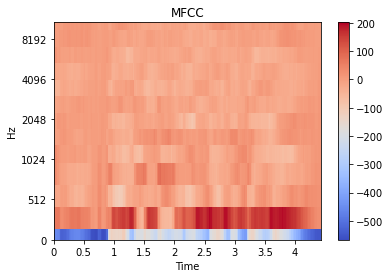

In [ ]:
# mfcc
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=13)

librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.title('MFCC')
plt.colorbar()
plt.show()

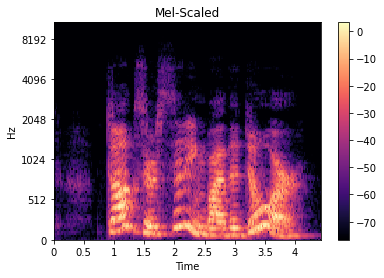

In [ ]:
# mel scaled spectogram
# mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=128)
mel = librosa.feature.melspectrogram(S=stft, n_mels=128)

mel_db = librosa.amplitude_to_db(abs(mel))

# normalized_mel = librosa.util.normalize(mel_db)

librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

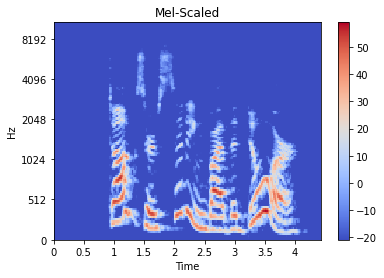

In [ ]:
mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=128)
# mel = librosa.feature.melspectrogram(S=stft, n_mels=128)

mel_db = librosa.amplitude_to_db(abs(mel))

# normalized_mel = librosa.util.normalize(mel_db)

librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

In [ ]:
# feature extraction

In [ ]:
def load_wav(path):
  # 22.05 kHz, 16 bit
  y, sr = librosa.load(path, mono=True)
  trimmed_y, idx = librosa.effects.trim(y, top_db=50) 
  normalized_y = librosa.util.normalize(trimmed_y)
  return normalized_y, sr

In [ ]:
def extract_mfcc(y, n_mfcc):
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
  normalized_mfcc = librosa.util.normalize(mfcc)

  return normalized_mfcc

def extract_mel(y, n_mel, n_fft, hop_length):
  stft = librosa.core.stft(y, n_fft=n_fft, hop_length=hop_length)

  mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mel)
  mel_db = librosa.amplitude_to_db(abs(mel))
  normalized_mel = librosa.util.normalize(mel_db)

  return normalized_mel

In [ ]:
# noise

def add_noise(y):
  noise = random.uniform(0.005, 0.008)
  noised_y = y + np.random.rand(len(y)) * noise

  return noised_y

In [ ]:
def add_padding(x, padding):
  padded_x = []

  for i in x:
    sh = len(i[0])

    if padding > 0 & sh < padding:
      x = padding - sh
      l_pad = x // 2
      r_pad = x - l_pad
      i = np.pad(i, pad_width=((0,0), (l_pad,r_pad)), mode='constant')

    padded_x.append(i)

  return padded_x

In [ ]:
mfcc = []
mel = []
label = []
max_mfcc_frame = 0
max_mel_frame = 0

add_aug = True

for idx, row in df.iterrows():
  y, sr = load_wav(row['path'])
  noised_y = add_noise(y)

  ex_mfcc = extract_mfcc(y, 13)
  ex_mel = extract_mel(y, 128, 2048, 512)

  mfcc.append(ex_mfcc)
  mel.append(ex_mel)
  label.append(row['emotion'])

  if add_aug:
    aug_mfcc = extract_mfcc(noised_y, 13)
    aug_mel = extract_mel(noised_y, 128, 2048, 512)

    mfcc.append(aug_mfcc)
    mel.append(aug_mel)
    label.append(row['emotion'])
  

  if max_mfcc_frame < ex_mfcc.shape[1]:
    max_mfcc_frame = ex_mfcc.shape[1]

  if max_mel_frame < ex_mel.shape[1]:
    max_mel_frame = ex_mel.shape[1]

  ipd.Audio(row['path'])

  break

padded_mfcc = add_padding(mfcc, max_mfcc_frame)
padded_mel = add_padding(mel, max_mel_frame)

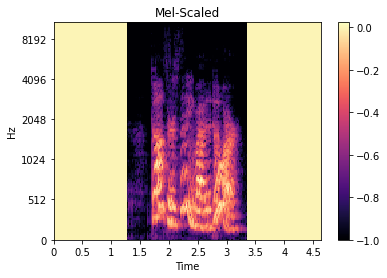

In [ ]:
librosa.display.specshow(padded_mel[0], x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

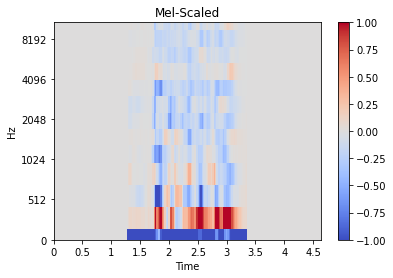

In [ ]:
librosa.display.specshow(padded_mfcc[0], x_axis='time', y_axis='mel')
plt.title('Mel-Scaled')
plt.colorbar()
plt.show()

In [ ]:
X_mfcc = np.array(padded_mfcc)
X_mel = np.array(padded_mel)
y = np.array(label)

np.save('X_mfcc', X_mfcc)
np.save('X_mel', X_mel)
np.save('y', y)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mv X_mel.npy X_mfcc.npy y.npy drive/MyDrive/SER